In [2]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
import functools
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import street_network_functions as snf
import utilities as uf
import simplify as sf
import warnings
warnings.filterwarnings('ignore')

C:\Users\g_filo01\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [3]:
reload(snf)
reload(uf)
reload(sf)

<module 'simplify' from 'C:\\Users\\g_filo01\\sciebo\\scripts\\Image of the City\\simplify.py'>

In [4]:
#initialise paths, names, etc.

city_name = 'London'
tmp_ouptut = 'Outputs/'+city_name+'/'+city_name
loading_path_nodes = ('C:/Users/g_filo01/sciebo/scripts/Image of the City/Outputs/'
                      +city_name+'/intermediate/'+city_name+'_nodes.shp')
loading_path_edges = ('C:/Users/g_filo01/sciebo/scripts/Image of the City/Outputs/'
                      +city_name+'/intermediate/'+city_name+'_edges.shp')
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

In [5]:
# loading original files
nodes_or = gpd.read_file(loading_path_nodes)
edges_or = gpd.read_file(loading_path_edges)

## Clipping or entire area?

In [12]:
# do you want to clip the area before simplifying 
clipping = False
path_polygon = 'C:/Users/g_filo01/sciebo/GIS Data/London/Congestion_area_polygon/Polygon.shp'

if clipping == True:
    if path_polygon != None: 
        polygon_clip = gpd.read_file(directory_polygon)
        buffer = polygon_clip.geometry.loc[0].buffer(800)
    else:
        # define the distance from the center of the UA within which you want to clip the data
        distance_from_center = 2000
        buffer = nodes.unary_union.envelope.centroid(distance)
    nodes = nodes_or[nodes_or.geometry.within(buffer)]
    edges = edges_or[edges_or.geometry.within(buffer)]
else: # entire area
    nodes, edges = nodes_or, edges_or

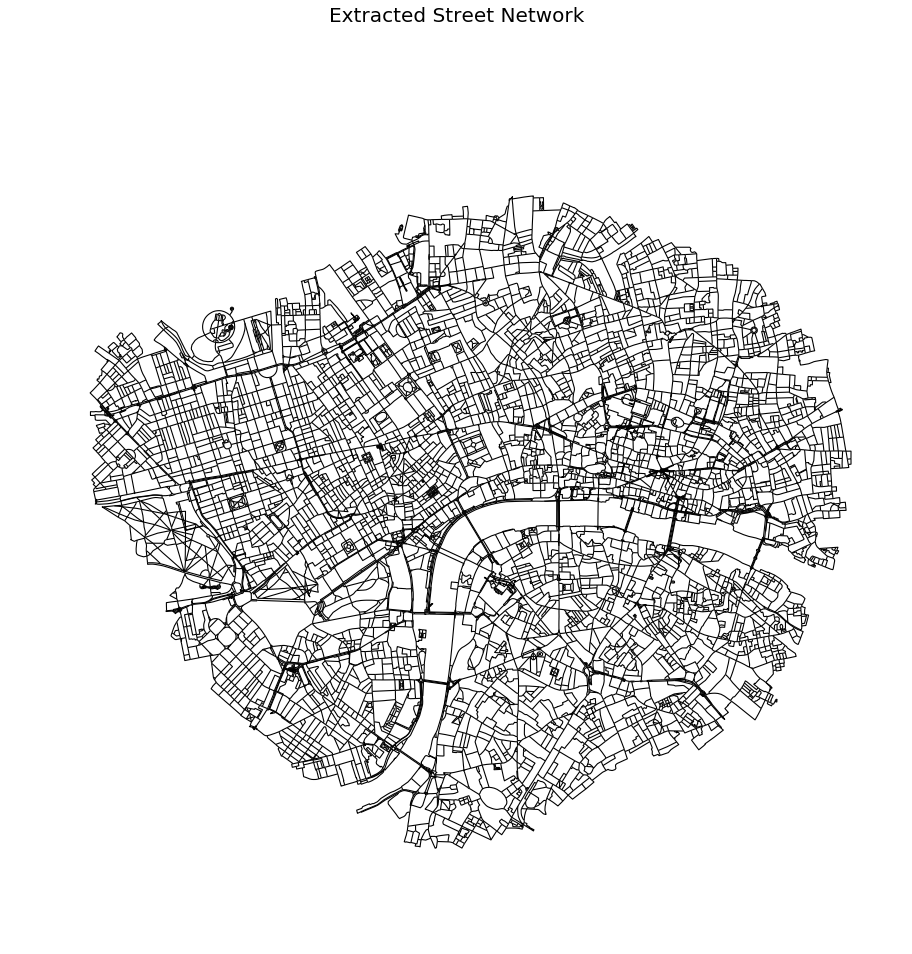

In [8]:
uf.plot_lines(edges, bb = False, f = 15, title = 'Extracted Street Network')

## Checking the network and cleaning it

In [14]:
nodes, edges = snf.clean_network(nodes, edges, detect_islands = True, dead_ends = True)
nodes_cleaned, edges_cleaned = nodes.copy(), edges.copy()

Correcting edges coordinates..
Done
Done after  0  cycles


In [108]:
# do you want to save the clipped version in its original configuration?
saving_clipped = True
if saving_clipped == True:
    saving_path ='C:/Users/g_filo01/sciebo/scripts/Image of the City/Outputs/'+city_name+'/intermediate/'+city_name
 
    # dual graph and scaling
    nodesDual_cleaned, edgesDual_cleaned = snf.dual_gdf(nodes_cleaned, edges_cleaned, crs)
    edges_cleaned['pedestrian'] *=1
    edges_cleaned.length = edges_cleaned.geometry.length
    edges_cleaned.drop('length_sc', axis = 1, inplace = True)

    col = ['Eb', 'Ab', 'length']
    for i in col: uf.scaling_columnDF(edges_cleaned, i, inverse = False)
    colDual = ['rad', 'deg']
    for i in colDual: uf.scaling_columnDF(edgesDual_cleaned, i, inverse = False)

    col = ['Bc_E', 'Bc_Rw', 'Rc400', 'Rc600', 'Bc_E_400', 'Bc_E_600', 'Bc_Rw_400', 'Bc_Rw_600']
    for i in col: uf.scaling_columnDF(nodes_cleaned, i, inverse = False)
    
    # converting lists
    to_convert = ['loc_land', 'loc_scor', 'dist_land', 'dist_scor', 'anchors', 'distances']
    nodes_cleaned_string = nodes_cleaned.copy()
    for column in to_convert: nodes_cleaned_string[column] = nodes_cleaned_string[column].astype(str)

    nodes_cleaned_string.to_file(saving_path+'_nodes.shp', driver='ESRI Shapefile')
    edges_cleaned.to_file(saving_path+'_edges.shp', driver='ESRI Shapefile')
    nodesDual_cleaned.drop('intersecting', axis = 1).to_file(saving_path+'_nodesDual.shp', driver='ESRI Shapefile')
    edgesDual_cleaned.to_file(saving_path+'_edgesDual.shp', driver='ESRI Shapefile')

# Simplification
## simplifying junctions

In [15]:
# nodes, edges = nodes_cleaned.copy(), edges_cleaned.copy()
nodes, edges = sf.simplify_dual_lines_junctions(nodes, edges, update_counts = True)
nodes, edges = sf.simplify_complex_junctions(nodes, edges, update_counts = True)

Simplifying intersections: first part -------------------------- 
Correcting edges coordinates..
Done
possible double edges 1
possible double edges 8
Correcting edges coordinates..
Done
Done after  2  cycles
Simplifying intersections: second part -------------------------- Triangle-Like-Junctions
Correcting edges coordinates..
Done
possible double edges 1
possible double edges 30
possible double edges 3
Correcting edges coordinates..
Done
Done after  3  cycles


## Extracting centroids from complex junctions
### e.g. roundabouts --> cluster of nodes

In [23]:
# nodes_correct, edges_correct = nodes.copy(), edges.copy()
nodes, edges = nodes_correct.copy(), edges_correct.copy()
nodes, edges, clusters, buffers = sf.extract_centroids(nodes, edges, radius = 7)

## Simplyfing dual lines

In [54]:
reload(sf)
nodes, edges, clusters = sf.simplify_dual_lines(nodes, edges, clusters, update_counts = True)

Simplifying dual lines: First part - clusters
3692 5915 OPTION 2 - SECTION 3
38934 38938 OPTION 2 - SECTION 1
36279 36310 OPTION 2 - SECTION 1
36682 64068 OPTION 2 - SECTION 2
18763 36667 OPTION 2 - SECTION 1
22047 36941 OPTION 2 - SECTION 1
27230 65038 OPTION 2 - SECTION 1
10508 16482 OPTION 2 - SECTION 1
16490 16546 OPTION 2 - SECTION 1
42910 70430 OPTION 2 - SECTION 1
16491 16548 OPTION 2 - SECTION 1
52917 62241 OPTION 2 - SECTION 1
52940 52996 OPTION 2 - SECTION 1
41692 43311 OPTION 2 - SECTION 1
43312 52104 OPTION 2 - SECTION 1
42912 70435 OPTION 2 - SECTION 1
70617 74905 OPTION 2 - SECTION 1
42102 46213 OPTION 2 - SECTION 2
8981 24673 OPTION 2 - SECTION 1
46650 46654 OPTION 2 - SECTION 1
27533 39540 OPTION 2 - SECTION 1
27529 27534 OPTION 2 - SECTION 1
36254 36257 OPTION 2 - SECTION 2
282 10514 OPTION 2 - SECTION 1
21193 43798 OPTION 2 - SECTION 2
47063 75715 not COMPLETED: OPTION 2 - SECTION 1
74908 75715 OPTION 2 - SECTION 1
14051 69473 OPTION 2 - SECTION 1
281 10588
perhaps he

15057 53808
perhaps here 1A 23
29863 29865
perhaps here 1B 12
15057 28315 not COMPLETED: OPTION 2 - SECTION 3
31075 31079 OPTION 2 - SECTION 1
45356 63869 OPTION 2 - SECTION 1
34993 36676 OPTION 2 - SECTION 1
39033 46324 OPTION 2 - SECTION 1
43614 48180 OPTION 2 - SECTION 1
21423 74339 OPTION 2 - SECTION 1
this may be the count 1
10491 41686 41699 OPTION 3 - SECTION 1
7978 9669 OPTION 2 - SECTION 1
21424 74340 OPTION 2 - SECTION 1
13230 20605
perhaps here 1B 6
20580 23527 OPTION 2 - SECTION 2
3577 3586 OPTION 2 - SECTION 1
34997 44532 OPTION 2 - SECTION 3
15304 15305 OPTION 2 - SECTION 1
this may be the count 3
64502 66313 68828 OPTION 3 - SECTION 1
32149 32187 OPTION 2 - SECTION 1
59720 60642 not COMPLETED: OPTION 2 - SECTION 1
59721 59786 OPTION 2 - SECTION 1
59720 60642 not COMPLETED: OPTION 2 - SECTION 1
35717 74372 OPTION 2 - SECTION 1
1449 1462 OPTION 2 - SECTION 1
24093 50693 OPTION 2 - SECTION 1
36209 49132 OPTION 2 - SECTION 1
1951 37050 OPTION 2 - SECTION 1
2030 2033 OPTION 2

3028 22528 OPTION 2 - SECTION 1
25473 51076 OPTION 2 - SECTION 2
9892 9901 not COMPLETED: OPTION 2 - SECTION 1
9892 9901 not COMPLETED: OPTION 2 - SECTION 1
4933 7294 OPTION 2 - SECTION 1
3658 9030 OPTION 2 - SECTION 3
67381 67384 OPTION 2 - SECTION 1
31690 38770 not COMPLETED: OPTION 2 - SECTION 1
31690 38770 not COMPLETED: OPTION 2 - SECTION 1
6387 6389 80621 OPTION 3 - SECTION 2
6388 13013 OPTION 2 - SECTION 1
13016 19266 OPTION 2 - SECTION 1
10037 10044 OPTION 2 - SECTION 1
82741 84536 OPTION 2 - SECTION 1
8055 67672 not COMPLETED: OPTION 2 - SECTION 1
8055 67672 not COMPLETED: OPTION 2 - SECTION 1
31700 81750 OPTION 2 - SECTION 1
31701 81751 OPTION 2 - SECTION 1
58186 39455
perhaps here 1B 0
3394 58185 OPTION 2 - SECTION 2
9928 9934 OPTION 2 - SECTION 1
2641 7279 OPTION 2 - SECTION 1
7330 49875 OPTION 2 - SECTION 1
7265 40922 OPTION 2 - SECTION 1
16580 16595 OPTION 2 - SECTION 1
31690 38770 not COMPLETED: OPTION 2 - SECTION 1
31690 38770 not COMPLETED: OPTION 2 - SECTION 1
67398 6

8417 28625
perhaps here 1B 1
4191 15959 28624 OPTION 3 - SECTION 2
4226 64475 OPTION 2 - SECTION 1
71899 81705 OPTION 2 - SECTION 3
71266 73824 not COMPLETED: OPTION 2 - SECTION 1
71266 73824 not COMPLETED: OPTION 2 - SECTION 1
22869 39448 not COMPLETED: OPTION 2 - SECTION 2
22869 39448 not COMPLETED: OPTION 2 - SECTION 2
2991 70960 OPTION 2 - SECTION 3
40991 41383 OPTION 2 - SECTION 1
2332 23969 OPTION 2 - SECTION 1
this may be the count 2
2279 37714 74856 OPTION 3 - SECTION 1
11404 34590 OPTION 2 - SECTION 1
2275 44077 OPTION 2 - SECTION 1
2276 22574 OPTION 2 - SECTION 2
12014 26073 OPTION 2 - SECTION 1
2278 44078 OPTION 2 - SECTION 1
22566 65806 OPTION 2 - SECTION 1
54052 74859 not COMPLETED: OPTION 2 - SECTION 1
54052 74859 not COMPLETED: OPTION 2 - SECTION 1
19301 83762 not COMPLETED: OPTION 2 - SECTION 1
19301 83762 not COMPLETED: OPTION 2 - SECTION 1
54052 74859 not COMPLETED: OPTION 2 - SECTION 1
54052 74859 not COMPLETED: OPTION 2 - SECTION 1
36937 66920 OPTION 2 - SECTION 1
t

In [ ]:
reload(sf)
nodes_simp, edges_simp = sf.simplify_dual_linesNodes(nodes, edges, clusters, update_counts = True)

## Resimplifying complex junctions

In [65]:
nodes, edges = nodes_simp.copy(), edges_simp.copy()
nodes, edges = sf.simplify_dual_lines_junctions(nodes, edges, update_counts = True)
nodes, edges = sf.simplify_complex_junctions(nodes, edges, update_counts = True)

Simplifying intersections: first part -------------------------- 
Correcting edges coordinates..
Done
possible double edges 0
possible double edges 2
Correcting edges coordinates..
Done
Done after  2  cycles
Simplifying intersections: second part -------------------------- Triangle-Like-Junctions
Correcting edges coordinates..
Done
possible double edges 0
possible double edges 5
Correcting edges coordinates..
Done
Done after  2  cycles


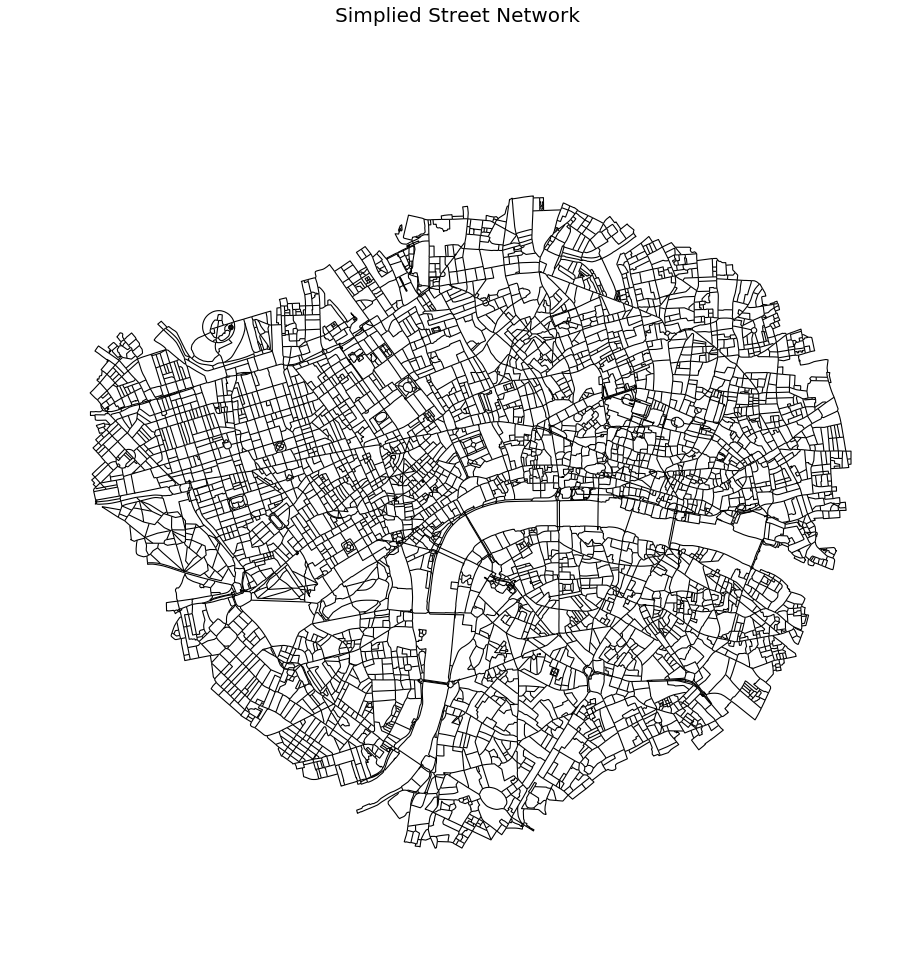

In [29]:
uf.plot_lines(edges, bb = False, f = 15, title = 'Simplied Street Network')

In [67]:
nodes_backup, edges_backup = nodes.copy(), edges.copy()

## Assigning visibility/ centrality mesaures to new nodes

In [68]:
nodes, edges = nodes_backup.copy(), edges_backup.copy()
nodes = sf.assign_vis(nodes, nodes_cleaned)

In [70]:
len(edges)

12958

In [72]:
file = 'C:/Users/g_filo01/sciebo/scripts/Image of the City/Outputs/'+city_name+'/intermediate/'+city_name+"_visibility_matrix.csv"
vm = pd.read_csv(file)
vm.drop('Unnamed: 0', axis = 1 , inplace = True)
vm.head()

,buildingID,0,1,4,8,10,12,13,15,16,...,32014,32015,32016,32018,32026,32027,32032,32033,32034,32036
0,34770,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34772,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34777,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34774,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,34778,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
nodeIDs = list(nodes.nodeID)
nodeIDs_original = list(nodes_cleaned.nodeID)
missing = [item for item in nodeIDs if item not in nodeIDs_original]
for i in missing: vm[str(i)] = 0
    
index_old = nodes.columns.get_loc("oldIDs")+1 

for row in nodes.itertuples():
    if not row[0] in missing: continue
    oldIDs = row[index_old]
    
    for i in oldIDs:
        tmp = vm[vm[str(i)] == 1]
        if len(tmp) < 1: continue
        to_change = list(tmp.buildingID)
        vm[str(row[0])][vm['buildingID'].isin(to_change)] = 1

In [74]:
to_keep = [str(i) for i in list(nodes.nodeID)]
to_keep = ['buildingID'] + to_keep
vm = vm[to_keep]
vm.head()

,buildingID,1,8,10,12,13,15,22,26,27,...,40504,40505,40506,40507,40508,40509,40510,40511,40512,40513
0,34770,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34772,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34777,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34774,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,34778,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# dual graph and scaling
nodesDual, edgesDual = snf.dual_gdf(nodes, edges, crs)
edges['pedestrian'] *=1
edges.length = edges.geometry.length
edges.drop('length_sc', axis = 1, inplace = True)

col = ['Eb', 'Ab', 'length']
for i in col: uf.scaling_columnDF(edges, i, inverse = False)
colDual = ['rad', 'deg']
for i in colDual: uf.scaling_columnDF(edgesDual, i, inverse = False)

In [76]:
col = ['Bc_E', 'Bc_Rw', 'Rc400', 'Rc600', 'Bc_E_400', 'Bc_E_600', 'Bc_Rw_400', 'Bc_Rw_600']
nodes = sf.assign_centrality(nodes, nodes_or, col)
for i in col: uf.scaling_columnDF(nodes, i, inverse = False)

In [77]:
saving_path ='C:/Users/g_filo01/sciebo/scripts/Image of the City/Outputs/'+city_name+'/intermediate/'+city_name

to_convert = ['loc_land', 'loc_scor', 'dist_land', 'dist_scor', 'anchors', 'distances', 'oldIDs']
nodes_string = nodes.copy()
for column in to_convert: nodes_string[column] = nodes_string[column].astype(str)
    
nodes_string.to_file(saving_path+'_nodes_simplified.shp', driver='ESRI Shapefile')
edges.to_file(saving_path+'_edges_simplified.shp', driver='ESRI Shapefile')
nodesDual.drop('intersecting', axis = 1).to_file(saving_path+'_nodesDual_simplified.shp', driver='ESRI Shapefile')
edgesDual.to_file(saving_path+'_edgesDual_simplified.shp', driver='ESRI Shapefile')
vm.to_csv(saving_path+'_visibility_matrix_simplified.csv')